## Anomaly detection with autoencoders

In this notebook we you have to create a fully-connected neural network based autoencoder in order to detect credit card frauds. In the dataset there are 492 labeled frauds and 284807 normal transactions. First, let's download the dataset and unpack it (original source of the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud - before downloading the data please read and accept the licence of the original datasource):

In [1]:
!wget https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip

--2024-05-09 19:03:23--  https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip
Resolving www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)... 91.227.138.51
Connecting to www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)|91.227.138.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  18.7MB/s    in 4.6s    

2024-05-09 19:03:28 (14.4 MB/s) - ‘creditcardfraud.zip’ saved [69155632/69155632]



In [2]:
%%capture
!unzip creditcardfraud.zip

## Imports
Import the necessary modules:

In [3]:
import pandas as pd #
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
np.random.seed(123)

## Exercise 1: Reading and preparing the data
Read the creditcard.csv into a Pandas Dataframe with the [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [4]:
df = pd.read_csv("creditcard.csv")

As the next step, select all the columns of the dataframe for the input X, but the "Class" column. And select the "Class" column for output Y. Make sure that both X and Y are two dimensional Numpy arrays.

Hint:
* you can use df.loc to select rows and columns from a dataframe
* you can get the Numpy array of a Pandas object with .values, eg. df['myfeature'].values

In [5]:
X = df.loc[:, df.columns != 'Class'].values
Y = df['Class'].values.reshape(-1, 1)

In [6]:
print("Shape of X:",X.shape)
print("Shape of Y:",Y.shape)

Shape of X: (284807, 30)
Shape of Y: (284807, 1)


Let's standardize the data:

In [7]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Exercise 2: defining the autoencoder
Let's define a model according to the following instructions:
* the model's inputs and outputs should be the same as the number of X's features (columns)
* the model should have 5 hidden layers, with 16-10-6-10-16 neurons in the hidden layers, respectively
* all layers but the output should have tanh activation
* the output layer should have linear activation

In [8]:
model = Sequential()
model.add(Dense(16, activation='tanh', input_shape=(X.shape[1],)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(X.shape[1], activation='linear'))

## Exercise 3: define early stopping compile the model, and train it
Please pay attention to the following details:
* use EarlyStopping with patience 10 and this time monitor the training loss
* do not define validation data
* use mean squarred error loss function
* both the input and output of the model should be X this time. (as we are "auto encoding" the input to the output)

In [9]:
patience = 10
es = EarlyStopping(monitor='loss', patience=patience, min_delta=0.01, restore_best_weights=True)

model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# training
network_history = model.fit(X, X,
                            epochs=80,
                            verbose=1)

Epoch 1/80
8901/8901 [==============================] - 39s 4ms/step - loss: 0.7256
Epoch 2/80
8901/8901 [==============================] - 34s 4ms/step - loss: 0.6168
Epoch 3/80
8901/8901 [==============================] - 33s 4ms/step - loss: 0.5944
Epoch 4/80
8901/8901 [==============================] - 33s 4ms/step - loss: 0.5687
Epoch 5/80
8901/8901 [==============================] - 33s 4ms/step - loss: 0.5519
Epoch 6/80
8901/8901 [==============================] - 34s 4ms/step - loss: 0.5327
Epoch 7/80
8901/8901 [==============================] - 32s 4ms/step - loss: 0.5240
Epoch 8/80
8901/8901 [==============================] - 34s 4ms/step - loss: 0.5200
Epoch 9/80
8901/8901 [==============================] - 34s 4ms/step - loss: 0.5169
Epoch 10/80
8901/8901 [==============================] - 32s 4ms/step - loss: 0.5149
Epoch 11/80
8901/8901 [==============================] - 33s 4ms/step - loss: 0.5130
Epoch 12/80
8901/8901 [==============================] - 33s 4ms/step - lo

## Results analysis
After training is done, we make predictions for the complete dataset and inspect the reconstruction loss. Our assumption is that, higher reconstruction loss are more likely to belong to anomalies than lower reconstruciton loss.

In [11]:
preds = model.predict(X)
errs  = np.square(preds-X)
errs  = np.mean(errs,axis=1)

8901/8901 [==============================] - 15s 2ms/step


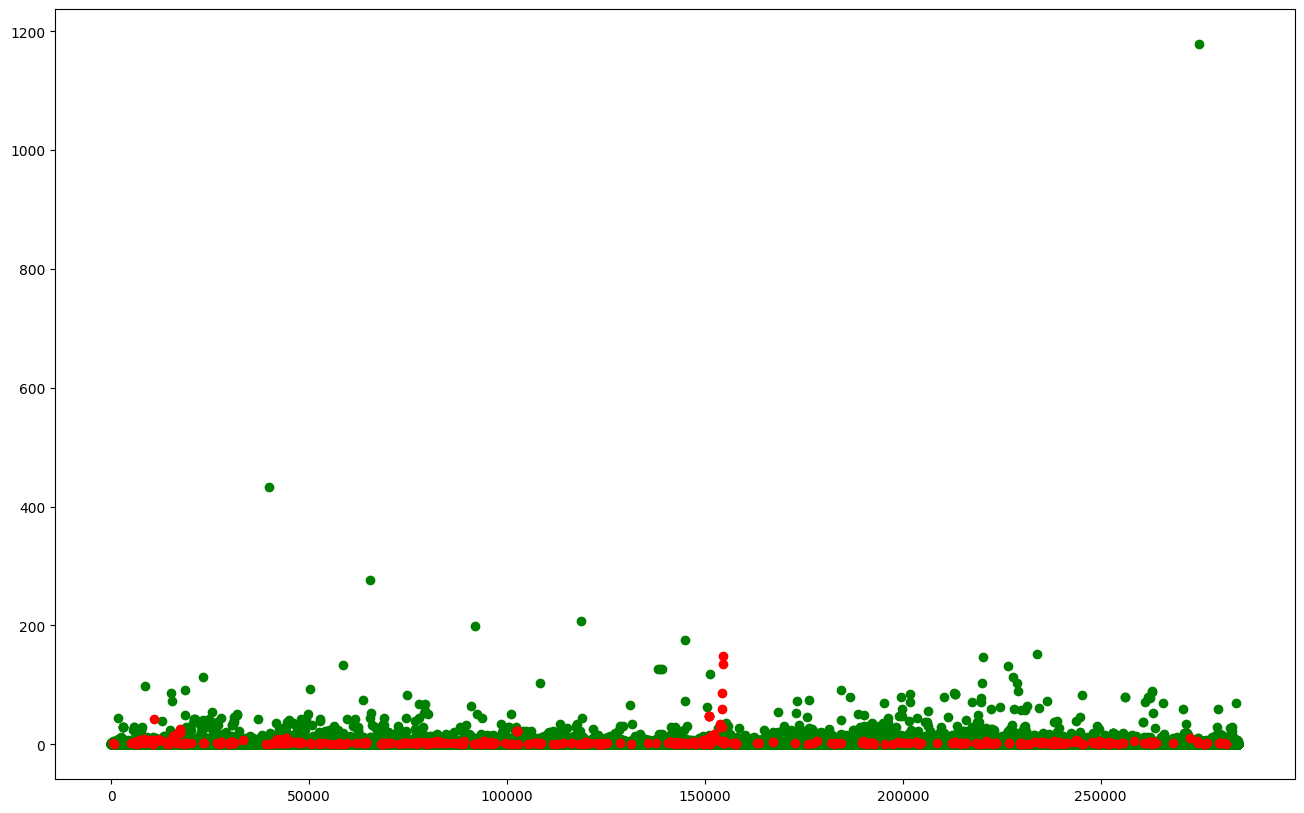

In [12]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs))
colors = ['g','r'] # green: normal, red: anomaly
for i in [0,1]:
    plt.scatter(rng[(Y==i).reshape(-1)], errs[(Y==i).reshape(-1)], color=colors[i])

In [13]:
Y_cut    = Y[errs<10]
errs_cut = errs[errs<10]

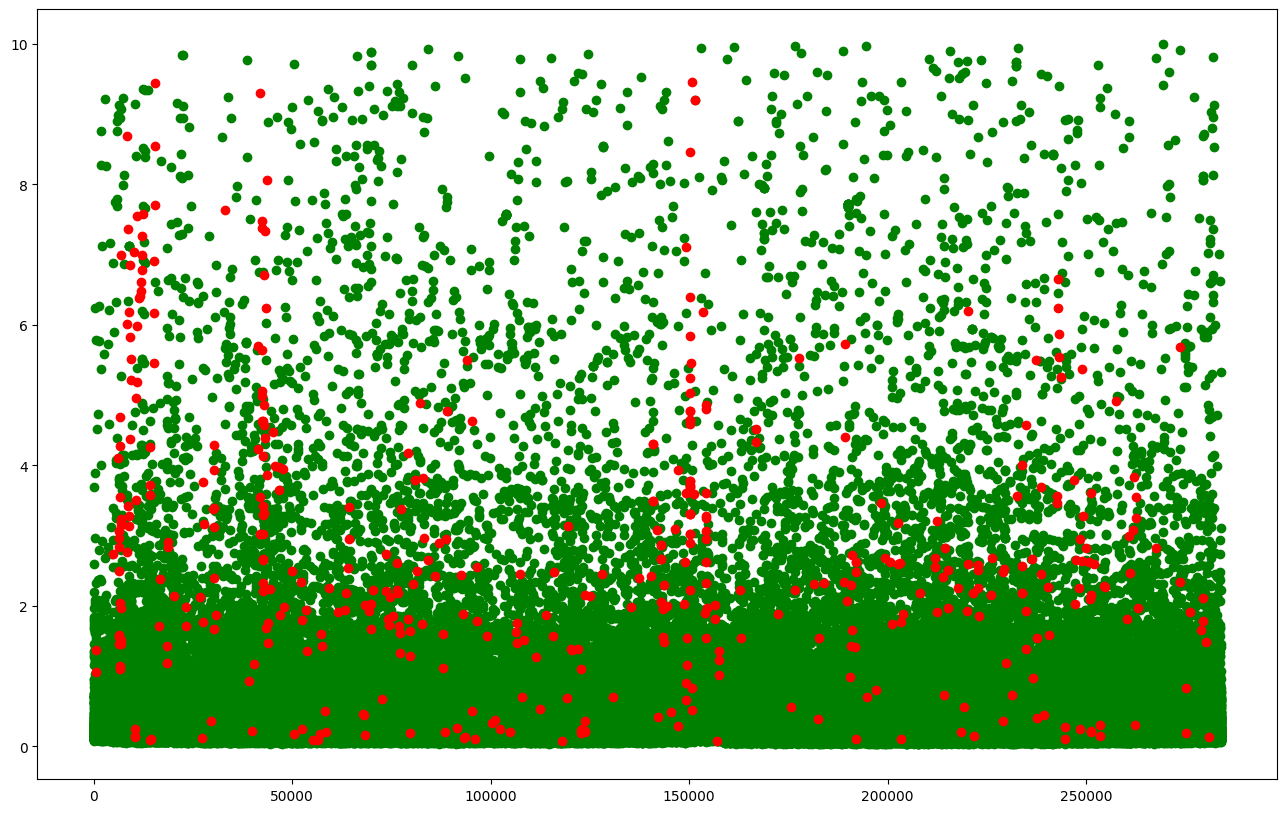

In [14]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs_cut))
colors = ['g','r']
for i in [0,1]:
    plt.scatter(rng[(Y_cut==i).reshape(-1)], errs_cut[(Y_cut==i).reshape(-1)], color=colors[i])

## Exercise 4: finding the right treshold
Find a treshold that identifies at least 130 anomalies correctly with as small number of missclassifications of non-anomalies as possible.

In [26]:
min_misclassifications = float('inf')
best_threshold = None

for threshold in range(1, 250000):
    errs_filtered = errs[errs > threshold]
    Y_filtered = Y[errs > threshold, 0]
    errs_filtered_non_anomalies = errs[errs <= threshold]
    Y_filtered_non_anomalies = Y[errs <= threshold, 0]

    num_anomalies_correct = len(errs_filtered[Y_filtered == 1])
    num_non_anomalies_misclassified = len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 1])

    if num_anomalies_correct >= 130 and num_non_anomalies_misclassified < min_misclassifications:
        min_misclassifications = num_non_anomalies_misclassified
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Number of misclassifications of non-anomalies:", min_misclassifications)

Best threshold: 1
Number of misclassifications of non-anomalies: 78


In [24]:
treshold = 1
errs_filtered               = errs[errs>treshold]
Y_filtered                  = Y[errs>treshold,0]
errs_filtered_non_anomalies = errs[errs<=treshold]
Y_filtered_non_anomalies    = Y[errs<=treshold,0]

print("Anomalies in the dataset") # Y_filtered==1
print("   predicted as anomaly:", len(errs_filtered[Y_filtered==1]))
print("   predicted as non-anomaly: ", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies==1]) )
print("Non-anomalies in the dataset") # Y_filtered ==0
print("   predicted as anomaly:", len(errs_filtered[Y_filtered==0]))
print("   predicted as non-anomaly:", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies==0]) )


Anomalies in the dataset
   predicted as anomaly: 414
   predicted as non-anomaly:  78
Non-anomalies in the dataset
   predicted as anomaly: 14836
   predicted as non-anomaly: 269479


We can also inspect the confusion matrix:

<Axes: >

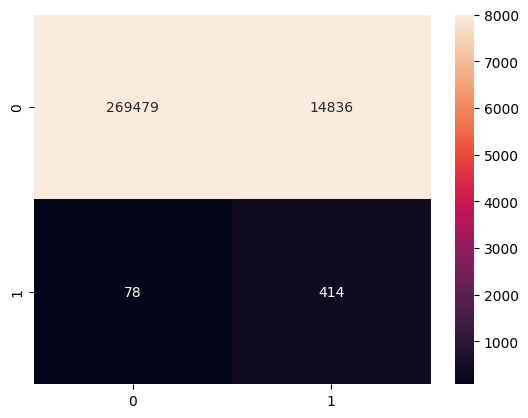

In [25]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(Y, errs>treshold)
import seaborn as sns
sns.heatmap(conf, annot=True, vmax=8000, fmt="d")